# Training a MLP classifier

sourced from https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

The aim of this exercise is to understand the usage of Multi-Layer
Perceptron: training process, meta-parameters and evaluation of the
system.

## Q1: Training with a validation dataset

The full dataset is split in 3 parts: training, validation and test.
Thus you can draw the learning curves ie the cost depending of the
iteration number. Try this using two cost values: the error rate and the
Mean Squared Error (MSE). Using this curves, choose the best weight set
optimizing the cost on the validation dataset (early stopping).

The first task is to complet the available algorithm with these steps:
1.  train for several mini-batches (not the full train set)
2.  compute the costs on training and validation sets and save the weights if the new model is better than the best
3.  continue the learning until the end of iterations
4.  return with the best neural network
5.  draw the curves
  
[Tips](../cours/3_mlp.html#/apprentissage-processus-itératiftraining-iterative-process-2)

## Q2: Procedural approach

Create a function that does the full training process which takes a network and all other parameters needed for training as inputs. The function should return the trained network and the learning curves. Use default values for the parameters to make the function easy to use.

Define also a function that takes the trained network and returns the accuracy of the network on the test set.


## Q3: Count the number of weights

Calculate the number of trainable parameters. Give the detailed calculation in plain text.

## Q4: Overfit MNIST

Modify the number of used training samples, MLP architecture and learning rate to create an overfiting situation.
Draw the curve showing that.



__Prénom :__ Mohamed  <br>
__Nom :__ Jaouada <br>
__Version de python :__ 3.12.3 <br>
__Machine utilisée :__ Machine personnelle <br>

In [1]:
import time
import copy
import torch
import torchvision
import torchvision.transforms as transforms

import os
#os.environ['HTTP_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'
#os.environ['HTTPS_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)


cpu


## Preparation of the dataset
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.Pad(2), # passer de 28 à 32 pixels
     transforms.ToTensor(), #faire calculs matricielles d'une façon optimisée
     transforms.Normalize((0.5,), (0.5,))])

# size of the mini batch
minibatchsize = 32

datadir = 'data'
fulltrainset = torchvision.datasets.MNIST(root=datadir, train=True,
                                        download=True, transform=transform) # telecharger le jeu de données, transform va etre effectué à chaque fois qu'on telecharge de nouveaux données

#split the full train part as train and validation (10K samples, some can be ignored):
trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [20000,10000, 30000]) # [apprentissage,validation,ignoré]

trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize,
                                          shuffle=True, num_workers=0)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.MNIST(root=datadir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize,
                                         shuffle=False, num_workers=0)

# define the set of class names :
classes = range(0,10)
nb_classes = len(classes)

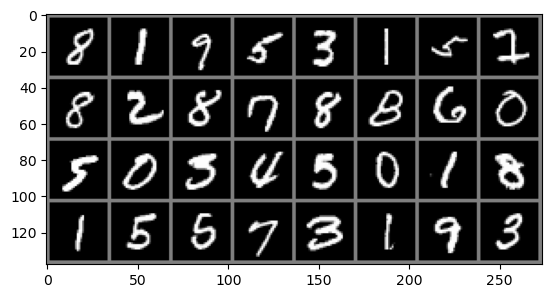

  8   1   9   5   3   1   5   7   8   2   8   7   8   8   6   0   5   0   3   4   5   0   1   8   1   5   5   7   3   1   9   3


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, filename=''):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if filename == '':
        plt.show()
    else:
        plt.savefig(name)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%3s' % classes[labels[j]] for j in range(minibatchsize)))


## Define a MLP


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# this class define the architecture
class NetMLP(nn.Module):
    # in the constructor, the usefull layers are defined, 
    # with the correct input/output dimensions
    def __init__(self, hiddencells = 100):
        super(NetMLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 , hiddencells)
        self.fc2 = nn.Linear(hiddencells, 10)
    
    # in the forward function, the layers are applied as functions
    # with the correct order and on a specific data x 
    # dimensions of x are [minibatch size, H, W]
    def forward(self, x):
        x = x.view(-1, 32 * 32) # x une matrice qui fait 32 * 1024
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [5]:
# Define the network to use :
net = NetMLP(100)
net.to(device) # move it to GPU or CPU
# show the structure :
print(net)

NetMLP(
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


# Define a Loss function and the optimizer

In [6]:
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network
This is the core part of the code, implementing the training loops. Answer Q1 with code.
(My answer is further below)

In [7]:
import numpy as np

# Definition of arrays to store the results and draw the learning curves
val_err_array = np.array([])
train_err_array = np.array([])
nb_sample_array = np.array([])

# best system results
best_val_loss = 1000000
best_nb_sample = 0
best_model =  copy.deepcopy(net)

nb_used_sample = 0
running_loss = 0.0
num_epochs = 5
print_every = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # if possible, move them to GPU

        # zero the parameter gradients  ************* Apprentissage ****************
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() 
        # *******************
        # count how many samples have been used during the training
        nb_used_sample += minibatchsize
        # print/save statistics
        running_loss += loss.item()
        if nb_used_sample % (print_every * minibatchsize) == 0:    # print every ""print_every"" mini-batches
            train_err = (running_loss / (print_every * minibatchsize))
            print('Epoch %d batch %5d ' % (epoch + 1, i + 1))
            print('Train loss : %.3f' % train_err)
            running_loss = 0.0
            #evaluation on validation set
            totalValLoss = 0.0
            with torch.no_grad():
                for data in validationloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    loss = criterion(outputs, labels)
                    totalValLoss += loss.item()
            val_err = (totalValLoss / len(validationset))
            print('Validation loss mean : %.3f' % val_err)
            train_err_array = np.append(train_err_array, train_err)
            val_err_array = np.append(val_err_array, val_err)
            nb_sample_array = np.append(nb_sample_array, nb_used_sample)

            # save the model only when loss is better
            best_model =  copy.deepcopy(net)
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))

print('Finished Training')

### save the best model :
# torch.save(best_model.state_dict(), "./best_model.nn")


Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.071
Epoch 1 batch   400 
Train loss : 0.070
Validation loss mean : 0.069
Epoch 1 batch   600 
Train loss : 0.068
Validation loss mean : 0.067
Epoch 1 of 5 took 14.666s
Epoch 2 batch   175 
Train loss : 0.065
Validation loss mean : 0.064
Epoch 2 batch   375 
Train loss : 0.062
Validation loss mean : 0.062
Epoch 2 batch   575 
Train loss : 0.061
Validation loss mean : 0.061
Epoch 2 of 5 took 15.463s
Epoch 3 batch   150 
Train loss : 0.060
Validation loss mean : 0.059
Epoch 3 batch   350 
Train loss : 0.058
Validation loss mean : 0.058
Epoch 3 batch   550 
Train loss : 0.057
Validation loss mean : 0.057
Epoch 3 of 5 took 17.163s
Epoch 4 batch   125 
Train loss : 0.057
Validation loss mean : 0.057
Epoch 4 batch   325 
Train loss : 0.056
Validation loss mean : 0.056
Epoch 4 batch   525 
Train loss : 0.056
Validation loss mean : 0.056
Epoch 4 of 5 took 17.508s
Epoch 5 batch   100 
Train loss : 0.055
Validation loss mean : 0.056

## Prepare and draw the training curves

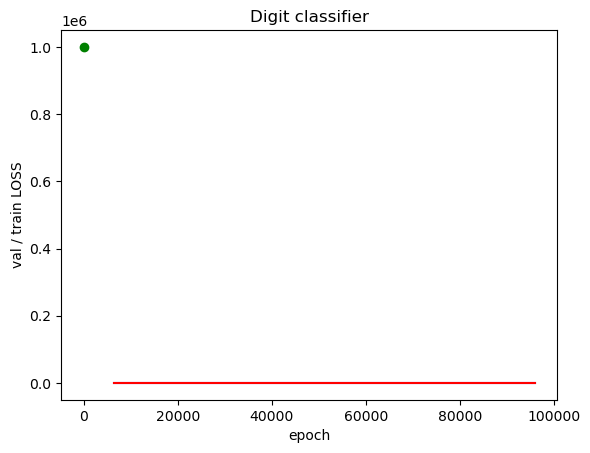

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.clf()
plt.xlabel('epoch')
plt.ylabel('val / train LOSS')
plt.title('Digit classifier')
plt.plot(nb_sample_array.tolist(), val_err_array.tolist(), 'b',nb_sample_array.tolist(), train_err_array.tolist(), 'r', [best_nb_sample], [best_val_loss],         'go')
plt.show()

## Test the network on the test data

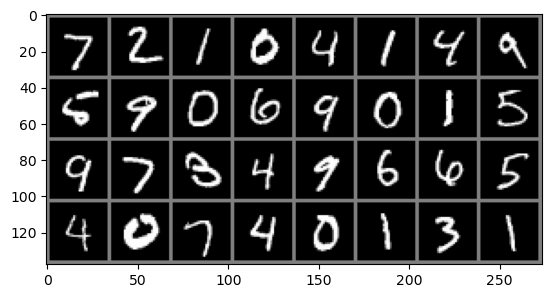

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1
Predicted:      7     2     1     0     9     1     9     9     2     9     0     6     9     0     1     3     9     7     3     9     9     6     6     8     9     0     7     9     0     1     3     1


In [9]:
# first on few sample, just to see real results
dataiter = iter(testloader)
images_cpu, labels_cpu = next(dataiter)
images, labels = images_cpu.to(device), labels_cpu.to(device)
plt.clf()
imshow(torchvision.utils.make_grid(images_cpu))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(minibatchsize)))
# activate the net with these examples
outputs = best_model(images)

# get the maximum class number for each sample, but print the corresponding class name
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(minibatchsize)))

In [10]:
# Test now  on the whole test dataset.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %3.2f %%' % (
    100.0 * correct / total))

Accuracy of the network on the test images: 74.35 %


In [11]:
# Check the results for each class
class_correct = list(0. for i in range(nb_classes))
class_total = list(0. for i in range(nb_classes))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# compute ... and show results

for i in range(nb_classes):
    if class_total[i] > 0 :
        print('Accuracy of %5s : %3.2f %% (%d/%d)' % (
            classes[i], 100.0 * class_correct[i] / class_total[i], class_correct[i] , class_total[i]))
    else:
        print('No %5s sample' % (classes[i]))

Accuracy of     0 : 96.94 % (950/980)
Accuracy of     1 : 97.53 % (1107/1135)
Accuracy of     2 : 86.14 % (889/1032)
Accuracy of     3 : 90.40 % (913/1010)
Accuracy of     4 : 0.00 % (0/982)
Accuracy of     5 : 0.00 % (0/892)
Accuracy of     6 : 94.47 % (905/958)
Accuracy of     7 : 89.20 % (917/1028)
Accuracy of     8 : 86.65 % (844/974)
Accuracy of     9 : 90.19 % (910/1009)


## Q1 :  Training with a validation dataset

In [12]:
# Commençant par definir la fonction compute_metrics() permettant de calculer le taux d'erreur 
# du classifieur (Nb d'individus malclassés/Nb total d'individus) ainsi que l'MSE
def compute_metrics(loader, net, device):
    total = 0
    correct = 0
    mse_loss = 0.0

    net.eval()  # Mode évaluation
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)

            # Prédictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Calcul de MSE
            mse_loss += F.mse_loss(outputs, F.one_hot(labels, num_classes=outputs.shape[1]).float()).item()

    error_rate = 1 - (correct / total)
    mse_loss /= len(loader)  # Moyenne

    return error_rate, mse_loss

In [ ]:
net = NetMLP(100).to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
best_model = copy.deepcopy(net)
best_val_error = float('inf')
best_val_mse = float('inf')
patience = 5  # Nombre d'époques sans amélioration avant d'arrêter (early stopping)
num_batches_per_epoch = 500  # Limite du nombre de mini-batchs par époque

# Stocker les valeurs pour les courbes
train_errors, val_errors = [], []
train_mses, val_mses = [], []

for epoch in range(num_epochs):  
    net.train()
    for i, data in enumerate(trainloader):
        if i >= num_batches_per_epoch:
            break

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calcul des métriques sur train et validation
    train_error, train_mse = compute_metrics(trainloader, net, device)
    val_error, val_mse = compute_metrics(validationloader, net, device)

    # Stocker les valeurs
    train_errors.append(train_error)
    val_errors.append(val_error)
    train_mses.append(train_mse)
    val_mses.append(val_mse)

    print(f"Epoch {epoch+1}: Train Error: {train_error:.4f}, Train MSE: {train_mse:.4f}, Val Error: {val_error:.4f}, Val MSE: {val_mse:.4f}")

    # Mise à jour du meilleur modèle (early stopping)
    if val_error < best_val_error or val_mse < best_val_mse:
        best_val_error = min(best_val_error, val_error)
        best_val_mse = min(best_val_mse, val_mse)
        best_model = copy.deepcopy(net)
        print("Nouveau meilleur modèle sauvegardé !")

print("Meilleur modèle chargé en mémoire !")
net = best_model  # Récupération du meilleur modèle

Epoch 1: Train Error: 0.6113, Train MSE: 0.0745, Val Error: 0.6188, Val MSE: 0.0750
Nouveau meilleur modèle sauvegardé !
Epoch 2: Train Error: 0.4285, Train MSE: 0.0575, Val Error: 0.4283, Val MSE: 0.0578
Nouveau meilleur modèle sauvegardé !
Epoch 3: Train Error: 0.2957, Train MSE: 0.0431, Val Error: 0.2985, Val MSE: 0.0435
Nouveau meilleur modèle sauvegardé !
Epoch 4: Train Error: 0.2727, Train MSE: 0.0404, Val Error: 0.2733, Val MSE: 0.0407
Nouveau meilleur modèle sauvegardé !
Epoch 5: Train Error: 0.2619, Train MSE: 0.0392, Val Error: 0.2613, Val MSE: 0.0393
Nouveau meilleur modèle sauvegardé !
Meilleur modèle chargé en mémoire !


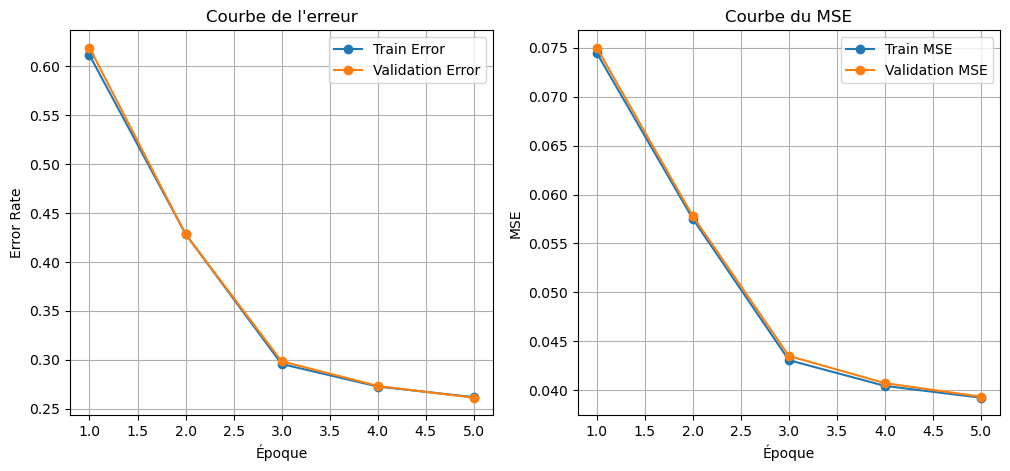

In [17]:
plt.figure(figsize=(12, 5))

# Courbe de l'Error Rate
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_errors) + 1), train_errors, label="Train Error", marker="o")
plt.plot(range(1, len(val_errors) + 1), val_errors, label="Validation Error", marker="o")
plt.xlabel("Époque")
plt.ylabel("Error Rate")
plt.title("Courbe de l'erreur")
plt.legend()
plt.grid()

# Courbe du Mean Squared Error (MSE)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_mses) + 1), train_mses, label="Train MSE", marker="o")
plt.plot(range(1, len(val_mses) + 1), val_mses, label="Validation MSE", marker="o")
plt.xlabel("Époque")
plt.ylabel("MSE")
plt.title("Courbe du MSE")
plt.legend()
plt.grid()

plt.show()

## Q2 : Procedural approach

In [18]:
# Commencant par une fonction permettant de tracer les courbes de taux d'erreur et d'MSE en entrainement et en validation
def plot_learning_curves(history):
    """Plots learning curves for error rate and MSE."""
    plt.figure(figsize=(12, 5))

    # Error Rate Curve
    plt.subplot(1, 2, 1)
    plt.plot(history["train_error"], label="Train Error", marker="o")
    plt.plot(history["val_error"], label="Validation Error", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Error Rate")
    plt.title("Error Rate Curve")
    plt.legend()
    plt.grid()

    # MSE Curve
    plt.subplot(1, 2, 2)
    plt.plot(history["train_mse"], label="Train MSE", marker="o")
    plt.plot(history["val_mse"], label="Validation MSE", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.title("Mean Squared Error Curve")
    plt.legend()
    plt.grid()

    plt.show()

In [19]:
# La fonction d'entrainement
def train_network(
    net,
    trainloader,
    valloader,
    device="cpu",
    criterion=nn.CrossEntropyLoss(),
    optimizer=None,
    num_epochs=5,
    num_batches_per_epoch=None,
    patience=5
):
    """
    Trains a neural network using mini-batches, tracks error rates and MSE, and applies early stopping.
    The function also draws the learning curves at the end.

    Parameters:
    - net: Neural network model.
    - trainloader: DataLoader for training set.
    - valloader: DataLoader for validation set.
    - device: Device for computation ('cpu' or 'cuda').
    - criterion: Cross Entropy Loss
    - optimizer: Optimizer (default: SGD).
    - num_epochs: Number of epochs (default: 5).
    - num_batches_per_epoch: Number of mini-batches per epoch (default: full dataset).
    - patience: Early stopping patience (default: 5).

    Returns:
    - best_net: The best trained model.
    - history: A dictionary containing the training history with the following keys:
        - 'train_error': List of training error rates per epoch.
        - 'val_error': List of validation error rates per epoch.
        - 'train_mse': List of mean squared errors on the training set per epoch.
        - 'val_mse': List of mean squared errors on the validation set per epoch.
    """

    net.to(device)
    if optimizer is None:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    best_net = copy.deepcopy(net)
    best_val_error = float("inf")
    best_val_mse = float("inf")
    wait = 0

    # Store metrics for plotting
    history = {"train_error": [], "val_error": [], "train_mse": [], "val_mse": []}

    for epoch in range(num_epochs):
        net.train()
        for i, data in enumerate(trainloader):
            if num_batches_per_epoch and i >= num_batches_per_epoch:
                break

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Compute metrics
        train_error, train_mse = compute_metrics(trainloader, net, device)
        val_error, val_mse = compute_metrics(valloader, net, device)

        history["train_error"].append(train_error)
        history["val_error"].append(val_error)
        history["train_mse"].append(train_mse)
        history["val_mse"].append(val_mse)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Error={train_error:.4f}, Train MSE={train_mse:.4f}, Val Error={val_error:.4f}, Val MSE={val_mse:.4f}")

        # Save the best model (early stopping)
        if val_error < best_val_error or val_mse < best_val_mse:
            best_val_error = min(best_val_error, val_error)
            best_val_mse = min(best_val_mse, val_mse)
            best_net = copy.deepcopy(net)
            print("Meilleur modele enregistré !")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping déclanché!")
                break

    return best_net, history

Epoch 1/5: Train Error=0.5994, Train MSE=0.0723, Val Error=0.6029, Val MSE=0.0731
Meilleur modele enregistré !
Epoch 2/5: Train Error=0.3610, Train MSE=0.0516, Val Error=0.3646, Val MSE=0.0524
Meilleur modele enregistré !
Epoch 3/5: Train Error=0.3388, Train MSE=0.0501, Val Error=0.3393, Val MSE=0.0504
Meilleur modele enregistré !
Epoch 4/5: Train Error=0.3345, Train MSE=0.0505, Val Error=0.3349, Val MSE=0.0507
Meilleur modele enregistré !
Epoch 5/5: Train Error=0.2661, Train MSE=0.0397, Val Error=0.2667, Val MSE=0.0399
Meilleur modele enregistré !


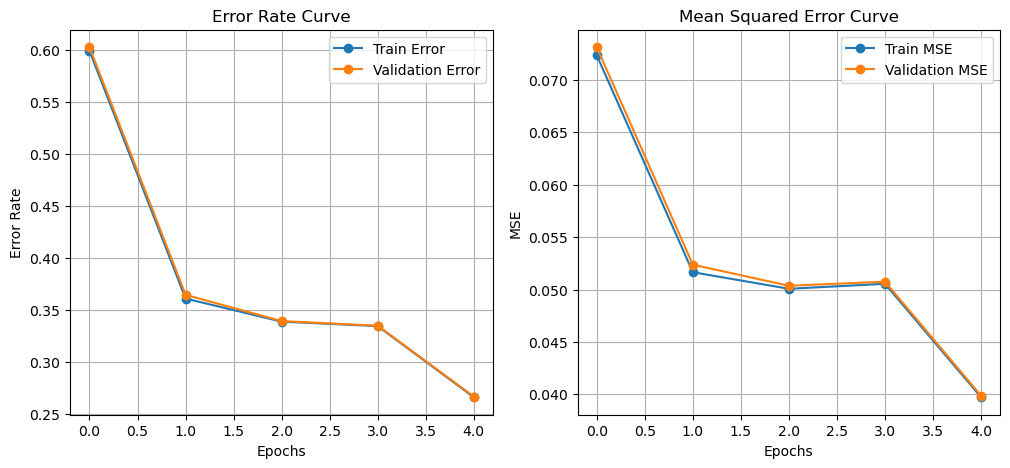

In [ ]:
net = NetMLP(100).to(device)
# Appel à la fonction créée pour entrainer le reseau de neurones
best_model, history = train_network(net, trainloader, validationloader)
# Tracer la courbe d'apprentissage
plot_learning_curves(history)

In [21]:
def evaluate_network(net):
    """
    Takes the trained network and returns the accuracy of the network on the test set.

    Parameters :
    - net : Trained neural network.

    Retourne :
    - accuracy : Recognition rate in percentage.
    """
    device="cpu"
    net.to(device)
    net.eval()  # Mode évaluation (désactive dropout, batchnorm)
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul des gradients
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)

            _, predicted = torch.max(outputs, 1)  # Prédiction = classe avec probabilité max
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"La precision (accuracy) du modèle sur le test set : {accuracy:.4%}")
    return accuracy


In [ ]:
# Appel à la fonction evaluate_network()
accuracy = evaluate_network(best_model)

La precision (accuracy) du modèle sur le test set : 73.8800%


## Q3 : Count the number of weights

In [24]:
# Calcul manuel : 
# On sait que la formule générale du nombre de paramètres libres d'un réseau de neurones, ayant une couche cachée, en fonction du nombre d’entrées n0, 
# nombre de sorties n2 et nombre de neurones dans la couche cachée n1 est : 
# Nb paramètres = n1 * (n0 + 1) + n2 * (n1 + 1)   Remarque : les +1 représentent les biais
# Ainsi, puisque dans notre réseau on a la couche cachée fc1 qui contient 100 neurones, chacun ayant 1024 entrées,
# et la couche fc2 qui contient 10 neurones, chacun ayant 100 entrées,
# on peut en déduire que le nombre de paramètres libres du réseau est :
# Nb paramètres libres = 100 * (1024 + 1) + 10 * (100 + 1) = 103510 paramètres

## Q4 : Overfit MNIST

In [25]:
# Afin de créer une situation de sur-apprentissage, on peut appliquer différentes modifications :
# On peut commencer par modifier l'architecture du MLP et le rendre plus complexe : 
class OverfittingMLP(nn.Module):
    def __init__(self, hiddencells=4500):
        super(OverfittingMLP, self).__init__()
        self.fc1 = nn.Linear(32*32, hiddencells)
        # On ajoute deux couches cachées supplémentaires contenant un nombre élevé de neurones
        self.fc2 = nn.Linear(hiddencells, hiddencells)
        self.fc3 = nn.Linear(hiddencells, hiddencells)
        self.fc4 = nn.Linear(hiddencells, hiddencells)
        self.fc5 = nn.Linear(hiddencells, hiddencells)
        self.fc6 = nn.Linear(hiddencells, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.softmax(self.fc6(x), dim=1)
        return x

In [26]:
# Une autre modification consiste à réduite la taille du jeu de données d'entrainement :
# Prendre seulement 350 exemples comme données d'entraînement pour forcer l'overfitting
trainset2, validationset2, _ignored_part = torch.utils.data.random_split(fulltrainset, [350,10000,len(fulltrainset)-(350+10000)])

trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=minibatchsize, shuffle=True, num_workers=0)
validationloader2 = torch.utils.data.DataLoader(validationset2, batch_size=minibatchsize,
                                          shuffle=False, num_workers=0)

Epoch 1/5: Train Error=0.8857, Train MSE=0.0899, Val Error=0.8871, Val MSE=0.0900
Meilleur modele enregistré !
Epoch 2/5: Train Error=0.8543, Train MSE=0.0898, Val Error=0.8929, Val MSE=0.0900
Epoch 3/5: Train Error=0.8543, Train MSE=0.0896, Val Error=0.8929, Val MSE=0.0901
Epoch 4/5: Train Error=0.8543, Train MSE=0.0895, Val Error=0.8929, Val MSE=0.0901
Epoch 5/5: Train Error=0.8543, Train MSE=0.0895, Val Error=0.8929, Val MSE=0.0903


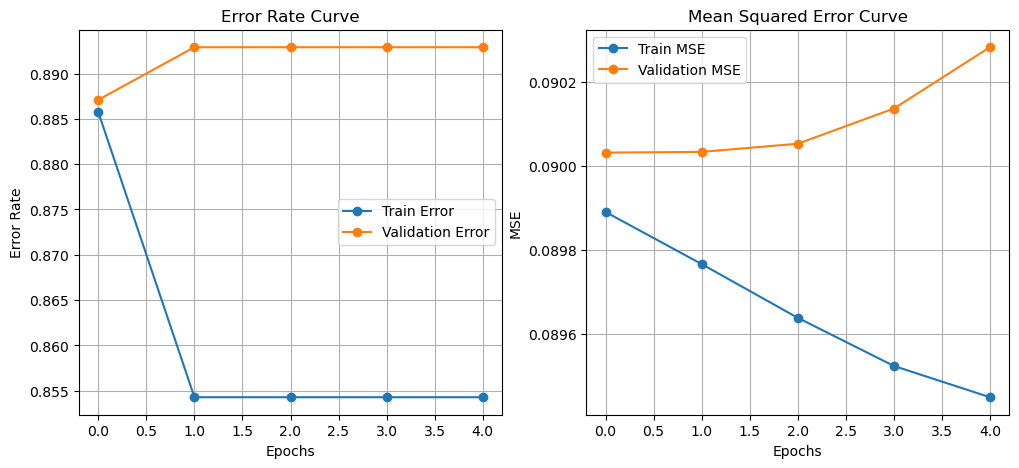

In [30]:
# Initialiser le nouveau modèle
net = OverfittingMLP(100)

# Augmenter le taux d'apprentissage
optimizer2 = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)  # lr = 0.1 au lieu de 0.001

# Lancer l'apprentissage
best_model, history = train_network(net, trainloader2, validationloader, optimizer=optimizer2)

# Tracer la courbe d'apprentissage
plot_learning_curves(history)

### Interprétation : 
* On peut clairement observer des signes de sur-apprentissage du modèle, en particulier sur les courbes du MSE d'entraînement et de validation. <br>Celles-ci commencent avec des valeurs relativement proches au premier epoch, mais s'écartent progressivement au fil des epochs, pour atteindre au cinquième epoch un Train MSE de 0.0895 et un Validation MSE de 0.0903.